# Convolutional Neural Network in Tensorflow for Medical Image Classification
----------------------
# Contents
- **Building (Convolutional) Models in TensorFlow**
    - Create train, val, and test data splits
    - Define the CNN model architecture
    - Train and plot training/val history
        - TensorBoard
        - Overfitting, underfitting, and good fit
    - Predict on test set using trained model
    - Plot confusion matrix
- **Model Interpretability using Grad-CAM**

-----------------------------
# [Section 1] Building (Convolutional) Models in TensorFlow

We've learned the basic convolution operation. One of its useful applications is to detect local features in a signal. In previous MPs/Labs, we used various fixed convolution kernels to detect straight lines (i.e., features) in the images. In the context of Convolutional Neural Networks (CNNs), we take this concept of feature detection a step further.

1. We apply multiple convolution kernels to capture different features in the image.
2. **The convolution kernels are learned parameters as opposed to manually set values like in edge detection.**

First, a set of different convolution kernels are applied to the image in parallel. Each of them scans over the entire image, targeting to capture different features. When the feature is detected, the convolution operation will output a strong signal in the result. Second, the exact values of the convolution kernels are not manually set, but learned from the data. Through a learning algorithm such as back-propagation, the CNN model learns the best kernels values to achieve its goal.

In [1]:
import os
path = '--xla_gpu_cuda_data_dir=/shared/BIOE488/FA24/conda/cudabio'
os.environ['XLA_FLAGS'] = path
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import os
import random
import matplotlib.pyplot as plt
from keras.src.legacy.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [4]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [5]:
tf.keras.backend.clear_session()

In this Lab, we will develop a convolutional neural network model to predict whether a person has pneumonia (label) given his chest x-ray image (input data).

### Create train, val, and test data splits

In [6]:
train_path = "/shared/BIOE488/FA24/data/chest_xray/train/"
test_path = "/shared/BIOE488/FA24/data/chest_xray/test/"
valid_path = "/shared/BIOE488/FA24/data/chest_xray/val/"

In [7]:
# TARGET_SIZE = (224,224)
TARGET_SIZE = (112,112)

# Creating train, test and valid batches from the respective directories
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=TARGET_SIZE, classes=['PNEUMONIA', 'NORMAL'], batch_size=64)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=TARGET_SIZE, classes=['PNEUMONIA', 'NORMAL'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=TARGET_SIZE, classes=['PNEUMONIA', 'NORMAL'], batch_size=64, shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# plot images in the form of a 1 by 10 grid and resize img to 20x20
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

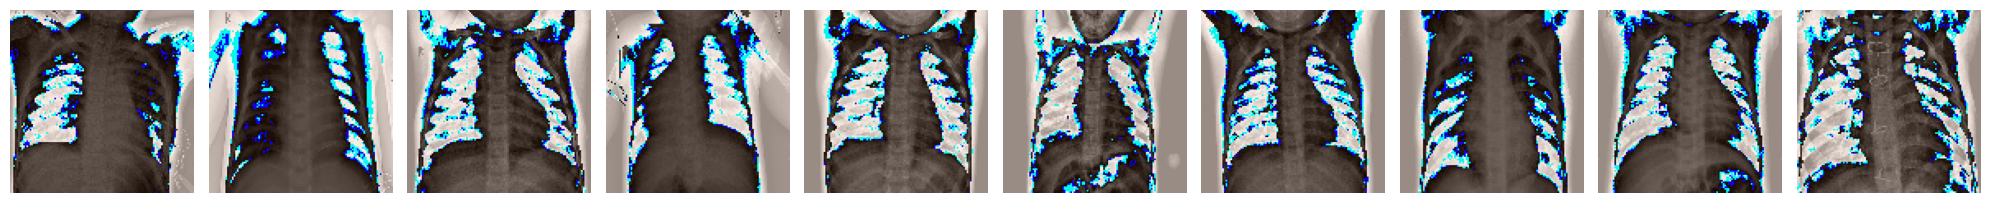

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [9]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels[:10])

### Define the CNN model architecture

In the following cell, we define the model architecture. The model consists of two convolutional layers with kernel size 3 by 3. The first layer is to have 32 kernels while the second one 64. Notice that after each convolutional layer, there is a max pooling layers to reduce the size of the image.

In [10]:
INPUT_SHAPE = (112,112,3)

model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=INPUT_SHAPE),
    MaxPool2D(pool_size=(4, 4), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(4, 4), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

/shared/BIOE488/FA24/conda/cudabio/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-06 20:24:59.737372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45554 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 55, 55, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        43,266 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,522 (248.13 KB)

 Trainable params: 63,522 (248.13 KB)

 Non-trainable params: 0 (0.00 B)

### Train and plot training/val history

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# https://www.tensorflow.org/tutorials/keras/save_and_load
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
from keras.callbacks import ModelCheckpoint, TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)
# launch tensorboard wwith logdir bioe488/fa22_bioe488_NETID/Lab8/logs/

filepath="./model_checkpoints/model-{epoch:02d}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False)
callbacks_list = [checkpoint, tensorboard]

# Fit the model
EPOCHS = 50
training_history = model.fit(
    x = train_batches,
    steps_per_epoch=train_batches.samples // 64, 
    epochs=EPOCHS, 
    validation_data=valid_batches, 
    validation_steps=valid_batches.samples // 10,
    callbacks=callbacks_list,
    verbose=2
)

/shared/BIOE488/FA24/conda/cudabio/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1733538326.127981  200185 service.cc:146] XLA service 0x7f121c003b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733538326.128046  200185 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-12-06 20:25:26.264430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-06 20:25:26.420700: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
I0000 00:00:1733538330.084476  200185 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: saving model to ./model_checkpoints/model-01.keras
81/81 - 63s - 776ms/step - accuracy: 0.8686 - loss: 1.4955 - val_accuracy: 0.8000 - val_loss: 1.3974
Epoch 2/50

Epoch 2: saving model to ./model_checkpoints/model-02.keras
81/81 - 0s - 2ms/step - accuracy: 0.9531 - loss: 0.6596 - val_accuracy: 0.7000 - val_loss: 2.0634
Epoch 3/50


/shared/BIOE488/FA24/conda/cudabio/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: saving model to ./model_checkpoints/model-03.keras
81/81 - 37s - 455ms/step - accuracy: 0.9556 - loss: 0.2465 - val_accuracy: 0.7000 - val_loss: 2.3091
Epoch 4/50

Epoch 4: saving model to ./model_checkpoints/model-04.keras
81/81 - 1s - 6ms/step - accuracy: 0.9531 - loss: 0.2172 - val_accuracy: 0.7000 - val_loss: 2.1180
Epoch 5/50

Epoch 5: saving model to ./model_checkpoints/model-05.keras
81/81 - 36s - 440ms/step - accuracy: 0.9641 - loss: 0.1615 - val_accuracy: 0.5000 - val_loss: 5.7852
Epoch 6/50

Epoch 6: saving model to ./model_checkpoints/model-06.keras
81/81 - 0s - 5ms/step - accuracy: 0.9375 - loss: 0.7948 - val_accuracy: 0.8000 - val_loss: 1.8965
Epoch 7/50

Epoch 7: saving model to ./model_checkpoints/model-07.keras
81/81 - 34s - 419ms/step - accuracy: 0.9678 - loss: 0.1574 - val_accuracy: 0.8000 - val_loss: 0.9840
Epoch 8/50

Epoch 8: saving model to ./model_checkpoints/model-08.keras
81/81 - 1s - 6ms/step - accuracy: 0.9844 - loss: 0.0350 - val_accuracy: 0.8000 -

In [14]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(training_history.history)
hist_df.to_csv("./training_history.csv", index=False)
hist_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.868595,1.495497,0.8,1.397420
1,0.953125,0.659607,0.7,2.063426
2,0.955551,0.246550,0.7,2.309134
3,0.953125,0.217202,0.7,2.118039
4,0.964092,0.161459,0.5,5.785243


['accuracy', 'loss', 'val_accuracy', 'val_loss']


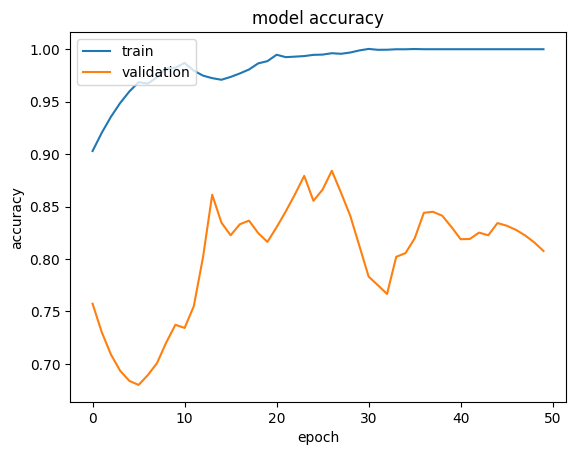

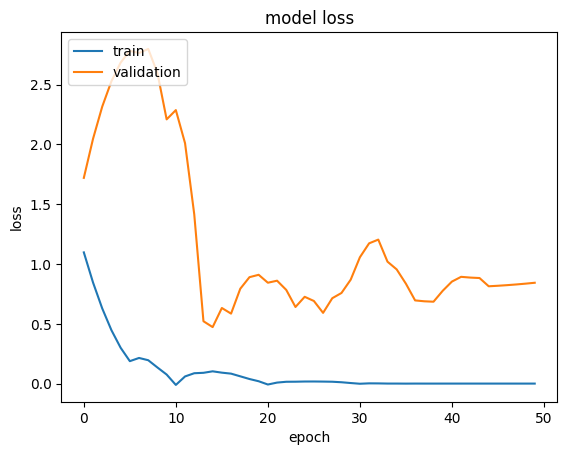

In [15]:
from scipy.signal import savgol_filter
WINDOW_LENGTH = 11

# load training history from file
import pandas as pd
hist_df = pd.read_csv("./training_history.csv")

print(hist_df.columns.tolist())
# summarize history for accuracy
plt.plot(savgol_filter(hist_df['accuracy'], window_length=WINDOW_LENGTH, polyorder=2))
plt.plot(savgol_filter(hist_df['val_accuracy'], window_length=WINDOW_LENGTH, polyorder=2))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(savgol_filter(hist_df['loss'], window_length=WINDOW_LENGTH, polyorder=2))
plt.plot(savgol_filter(hist_df['val_loss'], window_length=WINDOW_LENGTH, polyorder=2))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**[Exercise] Q: Based on the above training history, which model (approximately) should be selected as the best model?**

Your answer: 

It seems that the validation loss (metrics for choosing good models) are minimized at around 12-25 so the best model is around that range

In [17]:
# load weights for the best model based on the loss curve
best_epoch = 31
model.load_weights(f"./model_checkpoints/model-{str(best_epoch).zfill(2)}.keras")

In [18]:
# making predictions
predictions = model.predict(x = test_batches, verbose=0)

/shared/BIOE488/FA24/conda/cudabio/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Confusion matrix, without normalization
[[389   1]
 [141  93]]


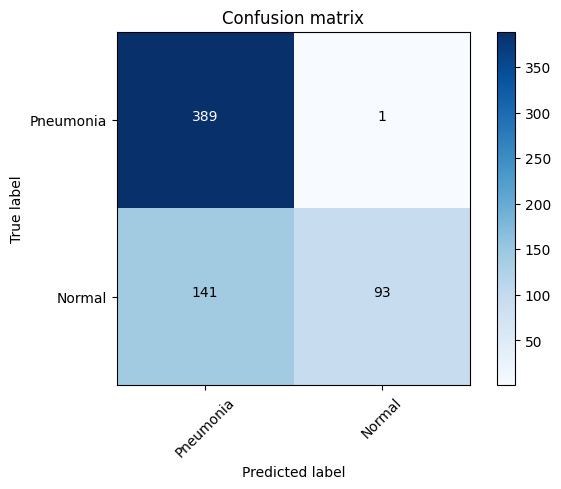

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm, classes = ['Pneumonia', 'Normal'])

**[Exercise] Q: Based on the confusion matrix, what type of mistakes is the model making? Are they acceptable in a clinical workflow?**

Your answer: 

Most of the mistakes are false positives, which might create a bit troubles for the doctors.

But the good news is that false negatives are low, which means that it is acceptable in clinics.

-----------------------------
# [Section 2] Model Interpretability using Grad-CAM

The basic idea behind Grad-CAM is: we want to exploit the spatial information that is preserved through convolutional layers, in order to understand which parts of an input image were important for a classification decision.

Grad-CAM uses the feature maps produced by the last convolutional layer of a CNN. The authors of Grad-CAM argue, “we can expect the last convolutional layers to have the best compromise between high-level semantics and detailed spatial information.”

**The output of Grad-CAM is a “class-discriminative localization map”, i.e. a heatmap where the hot part corresponds to a particular class.**

In summary:
- Grad-CAM is a popular technique for creating a class-specific heatmap based off of a particular input image, a trained CNN, and a chosen class of interest.
- Grad-CAM can be calculated on any CNN architecture as long the layers are differentiable.
- Grad-CAM has been used for weakly-supervised localization and weakly-supervised segmentation.

Read more: https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/

In [20]:
# load weights for the best model based on the loss curve
best_epoch = 30
model.load_weights(f"./model_checkpoints/model-{str(best_epoch).zfill(2)}.keras")

In [21]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

last_conv_layer_name = "conv2d_1"

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    cmap = cm.get_cmap("jet")

    # Use RGB values of the colormap
    cmap_colors = cmap(np.arange(256))[:, :3]
    cmap_heatmap = cmap_colors[heatmap]

    # Create an image with RGB colorized heatmap
    cmap_heatmap = keras.preprocessing.image.array_to_img(cmap_heatmap)
    cmap_heatmap = cmap_heatmap.resize((img.shape[1], img.shape[0]))
    cmap_heatmap = keras.preprocessing.image.img_to_array(cmap_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = cmap_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    display(superimposed_img)
    

# Code to plot colormap legend
import matplotlib as mpl
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh*3))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormap', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

In [22]:
# list test images
#!ls /shared/BIOE488/FA24/data/chest_xray/train/PNEUMONIA | head -n 50
!ls /shared/BIOE488/FA24/data/chest_xray/test/NORMAL | head -n 50

IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg
IM-0009-0001.jpeg
IM-0010-0001.jpeg
IM-0011-0001-0001.jpeg
IM-0011-0001-0002.jpeg
IM-0011-0001.jpeg
IM-0013-0001.jpeg
IM-0015-0001.jpeg
IM-0016-0001.jpeg
IM-0017-0001.jpeg
IM-0019-0001.jpeg
IM-0021-0001.jpeg
IM-0022-0001.jpeg
IM-0023-0001.jpeg
IM-0025-0001.jpeg
IM-0027-0001.jpeg
IM-0028-0001.jpeg
IM-0029-0001.jpeg
IM-0030-0001.jpeg
IM-0031-0001.jpeg
IM-0033-0001-0001.jpeg
IM-0033-0001-0002.jpeg
IM-0033-0001.jpeg
IM-0035-0001.jpeg
IM-0036-0001.jpeg
IM-0037-0001.jpeg
IM-0039-0001.jpeg
IM-0041-0001.jpeg
IM-0043-0001.jpeg
IM-0045-0001.jpeg
IM-0046-0001.jpeg
IM-0049-0001.jpeg
IM-0050-0001.jpeg
IM-0059-0001.jpeg
IM-0061-0001.jpeg
IM-0063-0001.jpeg
IM-0065-0001.jpeg
IM-0067-0001.jpeg
IM-0069-0001.jpeg
IM-0070-0001.jpeg
IM-0071-0001.jpeg
IM-0073-0001.jpeg
IM-0075-0001.jpeg
IM-0077-0001.jpeg
IM-0079-0001.jpeg
IM-0081-0001.jpeg


W0000 00:00:1733539454.062256  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.081201  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.081561  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.082035  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.082405  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.082819  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.083151  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.083481  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.119779  199018 gp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Prediction: [0]


/shared/BIOE488/FA24/conda/cudabio/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 112, 112, 3))
  warnings.warn(msg)
W0000 00:00:1733539454.558615  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.559042  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.559368  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.559686  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.560027  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733539454.560376  199018 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000

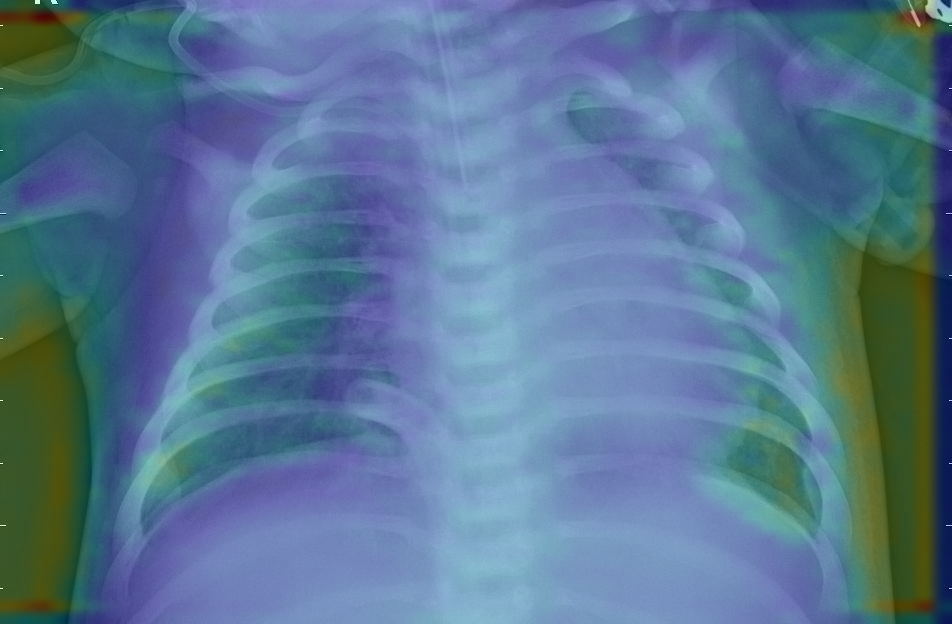

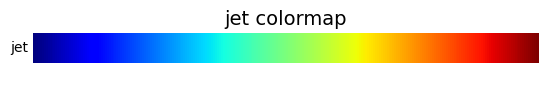

In [23]:
# Prepare image

# img_path = "/shared/BIOE488/FA24/data/chest_xray/train/PNEUMONIA/person1003_virus_1685.jpeg"
img_path = "/shared/BIOE488/FA24/data/chest_xray/test/PNEUMONIA/person117_bacteria_553.jpeg"
# img_path = "/shared/BIOE488/FA24/data/chest_xray/test/NORMAL/IM-0081-0001.jpeg"
# img_path = "/shared/BIOE488/FA24/data/chest_xray/test/NORMAL/IM-0030-0001.jpeg"

img_array = tf.keras.applications.vgg16.preprocess_input(get_img_array(img_path, size=TARGET_SIZE))

_ = model(img_array)

model_no_softmax = tf.keras.Model(model.inputs, model.layers[-2].output)

# Remove last layer's softmax
#model.layers[-1].activation = None

# Print what the top predicted class is
_ = model(img_array)
prediction = np.argmax(model.predict(img_array), axis=-1)
print("Prediction:", prediction)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_no_softmax, last_conv_layer_name)
#heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=1)

save_and_display_gradcam(img_path, heatmap)
plot_color_gradients('jet',['jet'])

**[Exercise] Q: Based on the above GRAD-CAM plots, do you think the model has been trained sufficiently? What can be done to improve the model?**

Your answer: 

After a couple of runs,I think the modelis pretty good highlighting the features around the lung. However, sometimes the highlighted region is not too focused and might look a little bit confusing and does not illustrate the object of interest. As for improvement, I think having more diversified data might help with preventing bias.

-----------------------
Read more: 
- https://keras.io/examples/vision/grad_cam/
- https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
- https://keras.io/examples/vision/integrated_gradients/
- https://keras.io/examples/vision/xray_classification_with_tpus/
- https://towardsdatascience.com/beginners-guide-to-building-convolutional-neural-networks-using-tensorflow-s-keras-api-in-python-6e8035e28238